### Importação de Bibliotecas

In [1]:
import numpy as np
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.applications import EfficientNetB0 # type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications.efficientnet import preprocess_input # type: ignore

### Definição de Parâmetros de Imagem

In [2]:
IMG_SIZE = 224 # Tamanho das imagens de entrada para a rede neural. Como está 244, todas as imagens serão redimensionadas para 224x224 pixels. Redes convolucionais como a EfficientNetB0 precisa que todas as imagens tenham o mesmo tamanho.
BATCH_SIZE = 32 # Número de imagens contendo em cada lote. Cada batch ou lote contém 32 imagens. Se estiver 1000 imagens, vai ter 31 batches com 32 imagens e 1 com 8 imagens.
CHANNELS = 3 # É o número de canais de cor da imagem. No caso, como é 3 canais, logo será a RGB (Red, Green, Blue).
NUM_CLASSES = 6 # Número de classes diferentes presentes no conjunto de dados. Há 6 categorias, o qual cada subpasta representa uma classe diferente.
EPOCHS = 30  # Numéro de vezes que o modelo irá ver todo o dataset no treinamento. Com 30 épocas, significa que cada imagem do dataset passará pelo modelo 30 vezes.
DATA_DIR = "../data/raw" # Diretório as imagens estão armazenados.

### Criação do Dataset

In [3]:
# Função lê uma pasta com subpastas (cada uma representando uma classe) contendo várias imagens e cria um dataset do tipo tf.data.Dataset
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR, # É o caminho da pasta, lembrando que essa pasta deverá ter subpastas, onde cada representa uma classe. Se a pasta tiver 4 subpastas, logo terá 4 classes
    shuffle=True, # Embaralhar as imagens, ou seja, cada lote terá o tamanho 32 (batch_size) e nessas 32 imagens serão de classes diferentes
    image_size=(IMG_SIZE, IMG_SIZE), # Redimensiona todas as imagens para ter o mesmo tamanho, porque as redes neurais precisam de entradas com formatos iguais
    batch_size=BATCH_SIZE, # Define quantas imagens terão por lote
)

Found 2527 files belonging to 6 classes.


### Visualização das informações sobre o Dataset

In [4]:
print(f"Quantidade de lotes(batch) no dataset: {len(dataset)}") # Informa quantas batch existe 
print(f"Quantidade de batch esperadas: {2527 / BATCH_SIZE}") # Dá 78,9 porque possui 78 batch com 32 imagens e a ultiam contem 31
print(f"Quantidade de imagens: {79 * 32}")

Quantidade de lotes(batch) no dataset: 79
Quantidade de batch esperadas: 78.96875
Quantidade de imagens: 2528


In [5]:
quantidade_imagens_total = 2527
imgs_batch_completa = 32 * 78
print(imgs_batch_completa)  # 78 lotes completos com 32 imagens cada, totalizando 2496 imagens
img_sobram = quantidade_imagens_total - imgs_batch_completa
print(img_sobram)  # Restam 31 imagens. Para usá-las, é criado um novo lote (79), que terá 31 imagens em vez de 32


2496
31


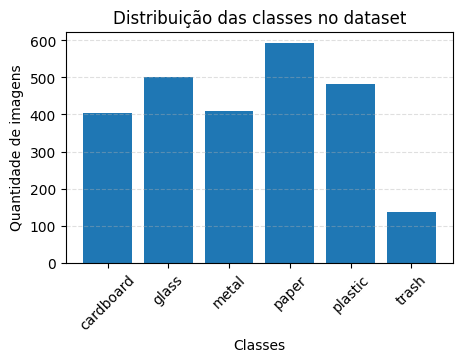

In [6]:
class_names = dataset.class_names # Pega os nomes das classes que são as mesmas que os nomes das subpastas
counts = collections.Counter() # Usando o counter vc pode contar quantas vezes cada classe aparece no dataset

for _, labels in dataset.unbatch(): # Vai desfazer os lotes e pegar cada label de todas as imagens
    counts[int(labels)] += 1 # Para cada label encontrada, vai aumentar a contagem dessa label

labels = class_names # Lista com os nomes da classes
values = [counts[i] for i in range(len(class_names))] # A quantidade de imagens por classe

plt.figure(figsize=(5, 3))
plt.bar(labels, values)
plt.xlabel("Classes")
plt.ylabel("Quantidade de imagens")
plt.title("Distribuição das classes no dataset")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


### Visualização de Rótulos e Imagens do Dataset

---
Entendendo a estrutura ao imprimir uma imagem:

* **1 `[ ... ]`**: A imagem completa
* **2 `[ ... ]`**: Cada sublista representa uma linha horizontal de pixels
* **3 `[R, G, B]`**: Um pixel (valores de Red, Green e Blue)

```python
[
  [ [R, G, B], [R, G, B], [R, G, B], ... ],  # 1ª linha (vários pixels)
  [ [R, G, B], [R, G, B], [R, G, B], ... ],  # 2ª linha
  ...
]
```
---

In [7]:
# Rótulos: a resposta correta de cada imagem — indica a qual classe cada imagem pertence
for __, labels in dataset.take(1):
    print("Shape dos rótulos:", labels.shape)       # Mostra quantos rótulos este batch contém. Como há 32 imagens, haverá 32 rótulos
    print("Primeiros rótulos:", labels.numpy()[:10]) # Mostra os rótulos das 10 primeiras imagens

Shape dos rótulos: (32,)
Primeiros rótulos: [0 0 3 1 2 4 3 4 3 3]


In [8]:
print("Classes disponíveis:", class_names)

for images, __ in dataset.take(1):
    print("Shape das imagens:", images.shape)  # [num_imagens (batch_size), altura, largura, canais de cores (RGB)]

    for i in range(4):  # Pegar as 4 primeiras imagens
        print(f"\nImagem {i+1}:")
        print("Forma:", images[i].shape)        # Altura, largura, canais de cores (RGB)
        print("Rótulo:", labels[i].numpy())   # Indica a qual classe a imagem pertence
        print("Rótulo (nome):", class_names[labels[i].numpy()])  # Mostra o nome da classe

Classes disponíveis: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Shape das imagens: (32, 224, 224, 3)

Imagem 1:
Forma: (224, 224, 3)
Rótulo: 0
Rótulo (nome): cardboard

Imagem 2:
Forma: (224, 224, 3)
Rótulo: 0
Rótulo (nome): cardboard

Imagem 3:
Forma: (224, 224, 3)
Rótulo: 3
Rótulo (nome): paper

Imagem 4:
Forma: (224, 224, 3)
Rótulo: 1
Rótulo (nome): glass


In [9]:
for images, __ in dataset.take(1):
    print(images[0].numpy())# Representação numericas e imagem no formato numpy

[[[223.35715 214.35715 199.35715]
  [223.35715 214.35715 199.35715]
  [223.35715 214.35715 199.35715]
  ...
  [241.      231.      219.     ]
  [242.      232.      220.     ]
  [242.35718 232.35718 220.35718]]

 [[224.07143 215.07143 200.07143]
  [224.07143 215.07143 200.07143]
  [224.07143 215.07143 200.07143]
  ...
  [241.      231.      219.     ]
  [242.      232.      220.     ]
  [242.35718 232.35718 220.35718]]

 [[225.78572 216.78572 201.78572]
  [225.78572 216.78572 201.78572]
  [225.78572 216.78572 201.78572]
  ...
  [241.      231.      219.     ]
  [242.      232.      220.     ]
  [242.35718 232.35718 220.35718]]

 ...

 [[240.28061 230.28061 218.28061]
  [239.07143 229.07143 217.07143]
  [237.61734 227.61734 215.61734]
  ...
  [245.33673 233.33673 219.33673]
  [245.2143  233.2143  219.2143 ]
  [245.2143  233.2143  219.2143 ]]

 [[240.      230.      218.     ]
  [238.14284 228.14284 216.14284]
  [236.80103 226.80103 214.80103]
  ...
  [245.78574 233.78574 219.78574]
  [2

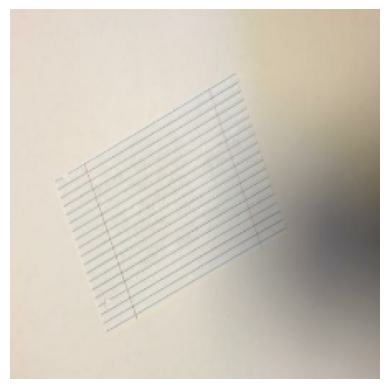

In [10]:
for images, __ in dataset.take(1): # Pega apenas o primeiro lote, que contém 32 imagens
    plt.imshow(images[0].numpy().astype("uint8"))  # Pega a primeira imagem do lote, converte para NumPy (para o Matplotlib entender) e transforma os valores dos pixels, que podem estar em float, para inteiros de 8 bits (0 a 255)
    plt.axis('off')


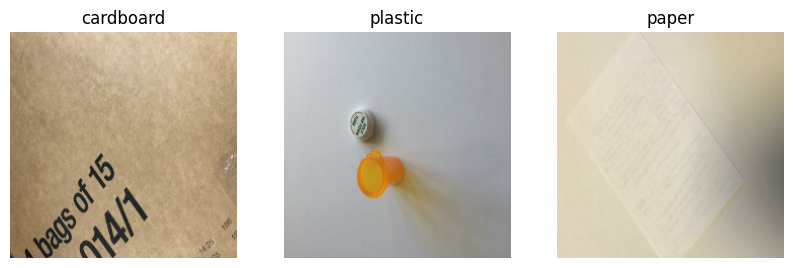

In [11]:
plt.figure(figsize=(10, 10))

for images, labels in dataset.take(1): 
    for i in range(3):  # vai exibir as 3 primeiras imagens do lote
        ax = plt.subplot(3, 3, i + 1)  # Cria um subplot 3x3, ou seja, serão 3 img por linha e 3 colunas. Se tentar exibir mais que 9, dá erro, pq foi definido como 3x3
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]]) # Vai mostrar o nome da classe que a imagem representa acima dela
        plt.axis("off")

### Divisão do Dataset em Treino, Validação e Teste

In [ ]:
def split_dataset(dataset, batch_size, train_ratio=0.8, val_ratio=0.1, seed=12):

    # Desfaz os batches para ter todas as imagens
    full_ds = dataset.unbatch() 

    # Realiza a contagem de imagens presentes no dataset
    ds_size = sum(1 for _ in full_ds) 
    print(f"Total de imagens: {ds_size}")

    # Recriar o dataset completo novamente , porque o primeiro foi consumido pela função acima
    full_ds = dataset.unbatch()

    # Vai embaralhar todas as imagens do dataset completo
    full_ds = full_ds.shuffle(buffer_size=ds_size, seed=seed)

    # Calcula o tamanho de cada subconjunto
    train_size = int(train_ratio * ds_size)
    print(f"Treino: {train_size} imagens")
    
    # Calcula o tamanho do conjunto de validação
    val_size = int(val_ratio * ds_size)
    print(f"Validação: {val_size} imagens")
    
    # Calcula o tamanho do conjunto de teste que vai ser feito pegando o que sobrou
    test_size = ds_size - train_size - val_size
    print(f"Teste: {test_size} imagens")

    # Realiza as divisões
    train_ds = full_ds.take(train_size).batch(batch_size)
    val_ds   = full_ds.skip(train_size).take(val_size).batch(batch_size)
    test_ds  = full_ds.skip(train_size + val_size).batch(batch_size)

    return train_ds, val_ds, test_ds, train_size, val_size, test_size

In [13]:
train_ds, val_ds, test_ds, train_size, val_size, test_size = split_dataset(dataset, BATCH_SIZE)

Total de imagens: 2527
Treino: 2021 imagens
Validação: 252 imagens
Teste: 254 imagens


### Otimização do Pipeline de Dados

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # Deixa o tensorflow ajusta automaticamente a quantidade ideal de cpu

# Cache (guarda o dataset nemoria - evitar que seja recarregado toda vez que for usado)
# Shuffle (Vai embaralhar o dataset de treino - garante que cada época veja os dados em uma ordem diferente)
# Prefetch (Carrega o proximo batch enquanto o atual esta sendo treinado - otimiza o tempo de espera) 
train_ds = train_ds.cache().shuffle(train_size).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

### Pré-processamento e Aumento de Dados

In [ ]:
# Data augmentation (faz tranformações nas imagens para aumentar a variedade do dataset)
# RandomFlip - Espaelhamento horizontal aleatório
# RandomRotation - Rotaciona a imagem aleatoriamente até 8%
# RandomZoom - Aplica um zoom aleatório na imagem até 8% 
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
])

# Resize - redimensaiona as imagens para o tamanho 224x224
# 1 Lambda - Converte a imgagem para float32 
# 2 Lambda - Aplica a funcão preprocess_input que normaliza a imagem conforme a EfficientNetB0 espera
preprocess_layer = tf.keras.Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Lambda(lambda x: tf.cast(x, tf.float32)),
    layers.Lambda(preprocess_input),
])

### Treinamento do modelo EfficientNetB0: Fase 1 - Treinar só a cabeça

In [ ]:
# Vai carregar o modelo EfficienteNetB0 (é uma rede neural leve e eficiente)
# include_top=False - nao vai carregar a parte final (cabeça de classificação), ou seja, o modelo matem apenas as camadas convolucionais e descarta a camadas densas que classificam 1000 classes da ImageNet
# Weights="imagenet" - Carrega os pesos tréinados originalmente na Imagemnet(14M de imagens) - Fazer Transfer Learning : usar conhecimento previo da rede para sua própria tarefa
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Isso vai congelar todas as camadas do efificientNetB0, ou seja, durante o treinamento os pesos dessas camadas não serão atualizados.
# Ele vai atua apenas como extrator de características fixas. É um passo tipico da primeira fase do Transfer Learning
base_model.trainable = False

In [ ]:

# Cria a entrada do modelo - Imagem RGB no formato (224, 224, 3)
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Aplica o pré-processamento criado antes (redimensionamento, conversão para float32 e normalização)
x = preprocess_layer(inputs)

# Aplica data augmentation
x = data_augmentation(x)

# Passa a imagem pelo modelo base (EfficientNetB0) - Trainging=False porque o modelo está congelado
x = base_model(x, training=False)

# Tranforma o mapa de características para reduzir a dimensionalidade
x = layers.GlobalAveragePooling2D()(x)

# Normaliza o vetor para melhorar a convergência e evitar valores extremos
x = layers.BatchNormalization()(x)

# Desliga aleatoriamente 30%
x = layers.Dropout(0.3)(x)

# Adiciona a camada densa com 128 neurônios
x = layers.Dense(128, activation="relu")(x)

# Normaliza novamete apos a camada densa 
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Camada final de classificao com softmax (converte em probabilidades)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

# Aqui vai contruir o modelo final
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,219,945 (16.10 MB)

 Trainable params: 167,558 (654.52 KB)

 Non-trainable params: 4,052,387 (15.46 MB)

In [ ]:
# Cria uma lista de callbacks que vão ser usados durante o treinamento do modelo
callbacks = [
    
    # O EarlyStopping vai monitorar a perda de validação (val_loss). Caso pare de melhorar o treino é interrompido para evitar overfitting
    # Patience=7 - Espera 7 épocas sem melhoria antes de parar o treinamento
    # Restore_best_weights=True - Após parar o treinamento, restaura os pesos do modelo para os melhores encontrados durante o treino
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=7, restore_best_weights=True
    ),
    
    # Vai salvar o modelo com o melhor desempenho
    tf.keras.callbacks.ModelCheckpoint(
        "../models/best_model.keras", save_best_only=True
    ),
]

In [ ]:
# Compilação do modelo 
# Optimizer - Difine o otimizador Adam com taxa de aprendizado de 0.001 - Adam é muito usado em transfer learning porque se adapta bem a diferentes tipos de problemas
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

print("\n--- Fase 1: treinando apenas a cabeça ---")

# Treina o modelo usando o dataset de treino e validacao 
# Vai ser treinado na primeira fase com 5 epocas e verbose=1 para mostrar a barra de progresso
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1,
)



--- Fase 1: treinando apenas a cabeça ---
Epoch 1/5
     64/Unknown 32s 381ms/step - accuracy: 0.5644 - loss: 1.3252

c:\Users\laris\OneDrive\Documents\Faculdade\project-a3-image-classification\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 461ms/step - accuracy: 0.6809 - loss: 0.9438 - val_accuracy: 0.9206 - val_loss: 0.4547
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 418ms/step - accuracy: 0.8135 - loss: 0.5220 - val_accuracy: 0.9048 - val_loss: 0.3434
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 417ms/step - accuracy: 0.8649 - loss: 0.4001 - val_accuracy: 0.9246 - val_loss: 0.2446
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 413ms/step - accuracy: 0.8763 - loss: 0.3369 - val_accuracy: 0.9325 - val_loss: 0.1973
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step - accuracy: 0.8966 - loss: 0.2841 - val_accuracy: 0.9524 - val_loss: 0.1526


### Treinamento do modelo EfficientNetB0: Fase 2 - Fine tuning

In [ ]:
total = sum(counts.values())

# Objetivo: é desbalancear as classes com menos imagens. Ou seja, classes com poucas imagens terão pesos maiores. Ajuda o modelo a não ignorar essas classes menoritárias durante o treinamento
class_weight = {
    i: total / (NUM_CLASSES * max(1, counts[i]))
    for i in range(NUM_CLASSES)
}
print("Class weights:", class_weight)

Class weights: {0: 1.0450785773366418, 1: 0.8406520292747838, 2: 1.0272357723577237, 3: 0.7090347923681257, 4: 0.873789764868603, 5: 3.0742092457420926}


In [ ]:
# Vai descongelar as ultimas 40 camadas do modelo base, ou seja, agora o efficientNetB0 não está mais congelado
base_model.trainable = True

# Conta quantas camadas existe no modelo e subtrai por 40  e o resultad o será a index da camada que vai começar a ser descongelada
# Se o modelo tem 237 camadas : fine_tune_at = 237 - 40 = 197. Ou seja, somente as ultimas 40 camadas serão destravadas para o treinamento
fine_tune_at = len(base_model.layers) - 40
for i, layer in enumerate(base_model.layers):
    layer.trainable = (i >= fine_tune_at)

print(f"\nDescongelando últimas 40 camadas (camada {fine_tune_at} até o final):")

# Compilar novamente o modelo 
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

# Vai treinar o modelo usando o a cabeça inteira + as ultimas 40 camadas do EfficientNetB0
print("\n--- Fase 2: fine tuning ---")
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1,
)



Descongelando últimas 40 camadas (camada 198 até o final):

--- Fase 2: fine tuning ---
Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 42s 517ms/step - accuracy: 0.8100 - loss: 0.5774 - val_accuracy: 0.9405 - val_loss: 0.1583
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 486ms/step - accuracy: 0.8308 - loss: 0.5220 - val_accuracy: 0.9484 - val_loss: 0.1759
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 481ms/step - accuracy: 0.8367 - loss: 0.4782 - val_accuracy: 0.9405 - val_loss: 0.1845
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - accuracy: 0.8313 - loss: 0.5149 - val_accuracy: 0.9484 - val_loss: 0.1866
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.8580 - loss: 0.4288 - val_accuracy: 0.9444 - val_loss: 0.1863
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 504ms/step - accuracy: 0.8511 - loss: 0.4164 - val_accuracy: 0.9444 - val_loss: 0.1856
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - accuracy: 0.8575 - loss: 0.3904 - val_accuracy: 0.9444 - val_loss: 0.1827
Epoch 8/

### Avaliação dos resultados do modelo

In [22]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}   Test loss: {test_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9488 - loss: 0.1463

Test accuracy: 0.9488   Test loss: 0.1463


In [ ]:
# Juntar os dois treinamentos
acc = history1.history["accuracy"] + history2.history["accuracy"]
val_acc = history1.history["val_accuracy"] + history2.history["val_accuracy"]

loss = history1.history["loss"] + history2.history["loss"]
val_loss = history1.history["val_loss"] + history2.history["val_loss"]

epochs_range = range(len(acc))

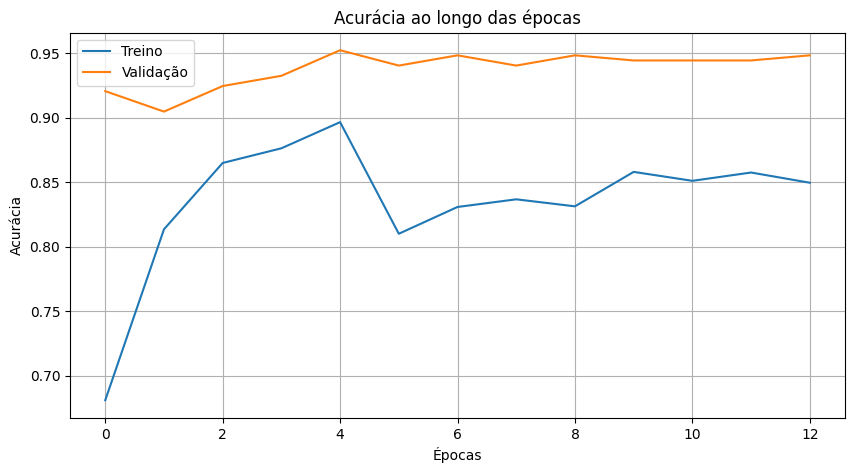

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, acc, label="Treino")
plt.plot(epochs_range, val_acc, label="Validação")
plt.title("Acurácia ao longo das épocas")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True)
plt.show()


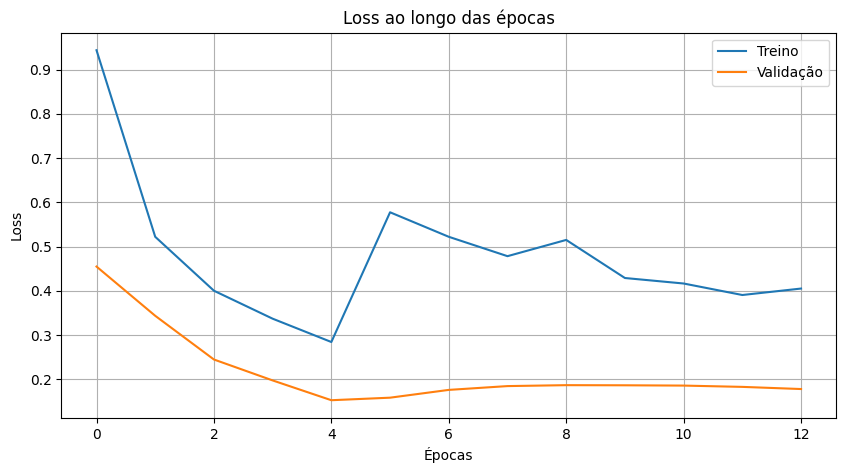

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, loss, label="Treino")
plt.plot(epochs_range, val_loss, label="Validação")
plt.title("Loss ao longo das épocas")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<Figure size 800x600 with 0 Axes>

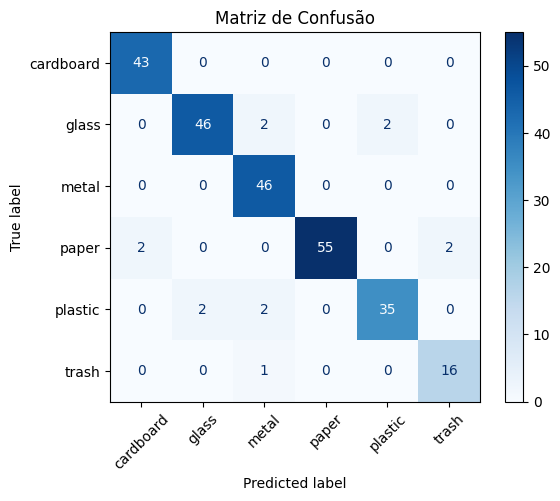

In [ ]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusão")
plt.show()


### Fazendo Predicoes com o modelo treinao

Avaliar Predição da Primeira Imagem: 


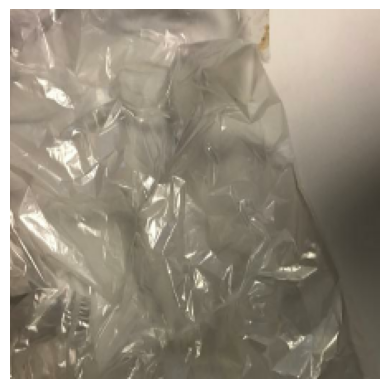

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
Probabilidades de cada classe para a primeira imagem:
 [1.6095513e-04 3.1184831e-03 1.3586472e-02 1.8017938e-03 5.9955113e-02
 9.2137724e-01]

Classe verdadeira: trash
Classe prevista pelo modelo:  trash


In [27]:
for images, labels in test_ds.take(1):
    primeira_imagem = images[0].numpy().astype("uint8")
    primeiro_rotulo = labels[0].numpy()
    
    print("Avaliar Predição da Primeira Imagem: ")
    plt.imshow(primeira_imagem)
    plt.axis("off")
    plt.show()
    
    predicao_batch = model.predict(images)
    
    print("Probabilidades de cada classe para a primeira imagem:\n", predicao_batch[0])
    
    print("\nClasse verdadeira:", class_names[primeiro_rotulo])
    print("Classe prevista pelo modelo: ", class_names[np.argmax(predicao_batch[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


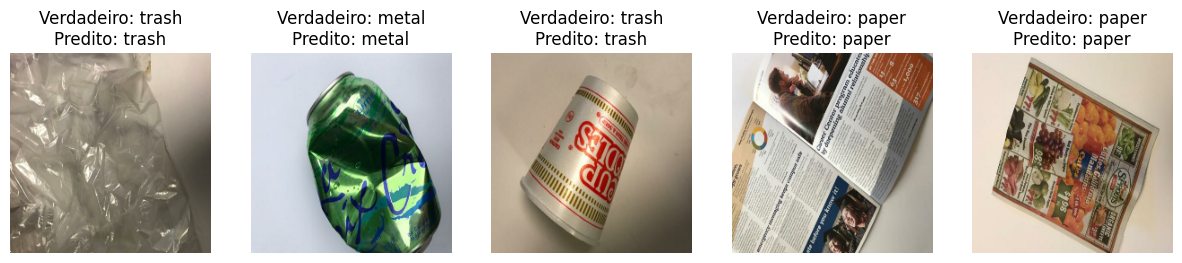

In [ ]:
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Verdadeiro: {class_names[labels[i]]}\nPredito: {class_names[preds_classes[i]]}")
        plt.axis("off")
    plt.show()
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


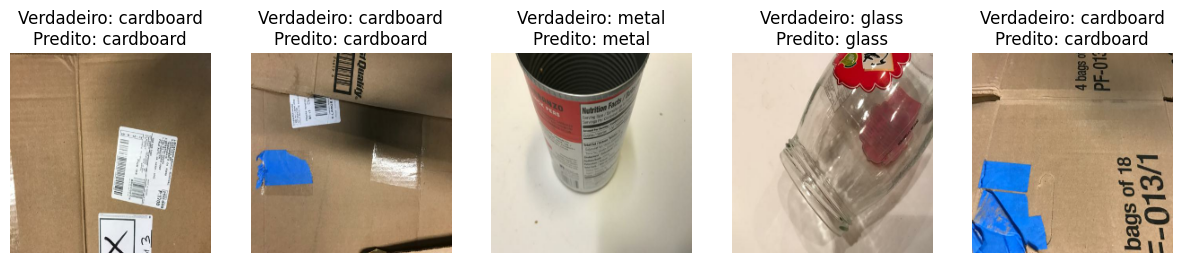

In [ ]:
import random

def testar_predicoes(dataset, n_imagens=5):
    all_images = []
    all_labels = []

    for images, labels in dataset.unbatch():
        all_images.append(images)
        all_labels.append(labels)

    indices = random.sample(range(len(all_images)), n_imagens)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        img = tf.expand_dims(all_images[idx], axis=0)
        pred = model.predict(img)
        pred_class = np.argmax(pred, axis=1)[0]

        plt.subplot(1, n_imagens, i + 1)
        plt.imshow(all_images[idx].numpy().astype("uint8"))
        plt.title(f"Verdadeiro: {class_names[all_labels[idx]]}\nPredito: {class_names[pred_class]}")
        plt.axis("off")
    plt.show()


testar_predicoes(test_ds, n_imagens=5)


In [30]:
model_version = 1
model.save(f"../models/image_classification_model_v{model_version}.keras")